In [258]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pymongo import MongoClient
from mplsoccer import Pitch
import json

client = MongoClient()
db = client['football_data']

In [215]:
home_team = 'Barcelona'
away_team = 'Real Madrid'

match = pd.DataFrame(list(db.matches.find({'home_team' : home_team, 'away_team' : away_team}))).iloc[0]
match_id = int(match['match_id'])

events = pd.DataFrame(list(db.events.find({'match_id' : match_id})))
lineups = pd.DataFrame(list(db.lineups.find({'match_id' : match_id})))

In [ ]:
import pandas as pd

home_team = match['home_team']
away_team = match['away_team']

# Filtry
home_events = events[events['team'] == home_team]
away_events = events[events['team'] == away_team]

# --- Funkcje pomocnicze ---
def count_shots(df):
    return len(df[df['type'] == 'Shot'])
home_shots = count_shots(home_events)
away_shots = count_shots(away_events)

def count_shots_on_target(df):
    return len(df[(df['type'] == 'Shot') & (df['shot_outcome'].isin(['Goal', 'Saved']))])
home_on_target = count_shots_on_target(home_events)
away_on_target = count_shots_on_target(away_events)

def sum_xg(df):
    return round(df[df['type'] == 'Shot']['shot_statsbomb_xg'].sum(), 2)
home_xg = sum_xg(home_events)
away_xg = sum_xg(away_events)

def count_passes(df):
    return df[df['type'] == 'Pass']
home_passes = count_passes(home_events)
away_passes = count_passes(away_events)

def count_accurate_passes(df):
    passes = count_passes(df)
    return len(passes[passes['pass_outcome'].isnull()])  # nan = celne

def pass_accuracy_pct(df):
    passes = count_passes(df)
    total = len(passes)
    accurate = count_accurate_passes(df)
    return f"{(accurate / total) * 100:.1f}%" if total > 0 else "0.0%"

def count_corners(df):
    return len(df[df['type'] == 'Corner'])

def count_penalties(df):
    shots = df[df['type'] == 'Shot']
    if 'shot' not in shots.columns:
        return 0
    return shots['shot'].apply(lambda s: isinstance(s, dict) and s.get('penalty') == True).sum()


def count_cards(lineups_data, team, card_type):
    return sum(
        1 for player in lineups_data.get(team, [])
        for card in player.get("cards", [])
        if card.get("card_type") == card_type
    )

def count_interceptions(df):
    return len(df[df['type'] == 'Interception'])

def count_tackles_won(df):
    duels = df[df['type'] == 'Duel']
    if 'duel' not in duels.columns:
        return 0
    return duels['duel'].apply(lambda d: (
        isinstance(d, dict) and
        d.get('type', {}).get('name') == 'Tackle' and
        d.get('outcome', {}).get('name') == 'Won'
    )).sum()


# --- Statystyki ---
statystyki = {
    'Gole': [match['home_score'], match['away_score']],
    'Strzały': [home_shots, away_shots],
    'Strzały celne': [home_on_target, away_on_target],
    'xG': [home_xg, away_xg],
    'Celne podania': [count_accurate_passes(home_events), count_accurate_passes(away_events)],
    '% celnych podań': [pass_accuracy_pct(home_events), pass_accuracy_pct(away_events)],
    'Rzuty rożne': [count_corners(home_events), count_corners(away_events)],
    'Rzuty karne': [count_penalties(home_events), count_penalties(away_events)],
    'Żółte kartki': [count_cards(lineups_data, home_team, 'Yellow Card'),
                     count_cards(lineups_data, away_team, 'Yellow Card')],
    'Czerwone kartki': [count_cards(lineups_data, home_team, 'Red Card'),
                        count_cards(lineups_data, away_team, 'Red Card')],
    'Przechwyty': [count_interceptions(home_events), count_interceptions(away_events)],
    'Odbiory': [count_tackles_won(home_events), count_tackles_won(away_events)],
}

# --- Tabela końcowa ---
stats_df = pd.DataFrame.from_dict(statystyki, orient='index', columns=[home_team, away_team])
stats_df.index.name = 'Statystyka'

# Wyświetlenie
stats_df


,Barcelona,Real Madrid
Statystyka,,
Gole,1,2
Strzały,14,15
Strzały celne,3,6
xG,0.73,1.32
Celne podania,645,279
% celnych podań,90.6%,79.7%
Rzuty rożne,0,0
Rzuty karne,0,0
Żółte kartki,3,3


In [267]:
print(events['pass_outcome'].unique())


[nan 'Incomplete' 'Pass Offside' 'Out' 'Unknown']


In [238]:
print(f"{match['home_team']} vs {match['away_team']}")
print(f"Wynik: {match['home_score']} - {match['away_score']}")
print(f"Data: {match['match_date']}")
print(f"Kolejka: {match.get('match_week')}")
print(f"Stadion: {match.get('stadium')}")

referee = match.get('referee')
print(f"Sędzia: {'brak danych' if pd.isna(referee) else referee}")


Barcelona vs Real Madrid
Wynik: 1 - 2
Data: 2016-04-02
Kolejka: 31
Stadion: Spotify Camp Nou
Sędzia: brak danych


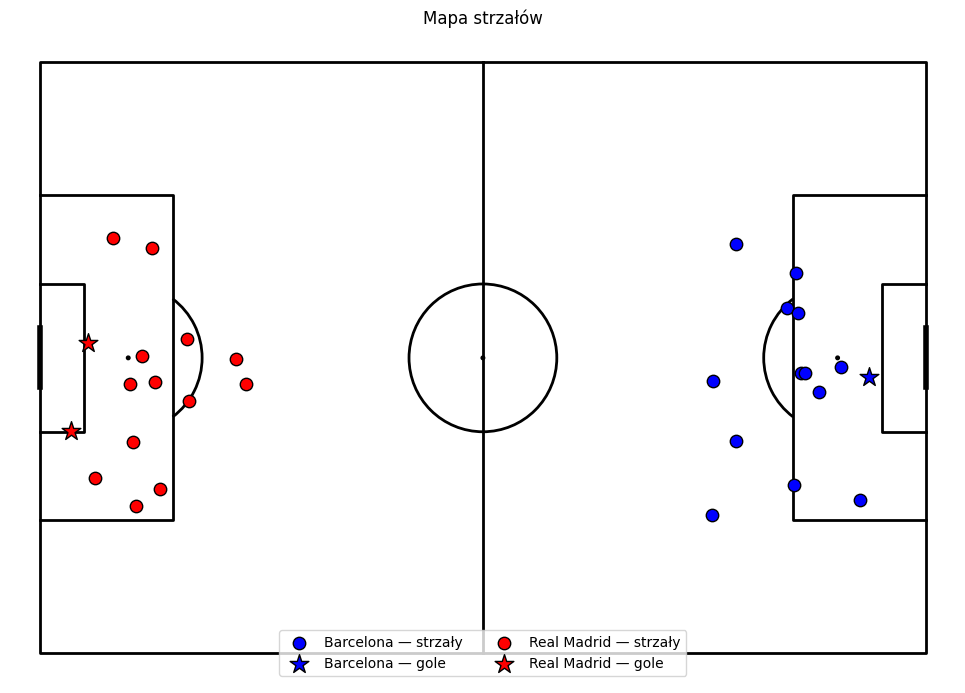

In [251]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# --- Przygotowanie danych ---
shots = events[(events['type'] == 'Shot') & (events['location'])].copy()
shots['x'] = shots['location'].apply(lambda loc: loc[0])
shots['y'] = shots['location'].apply(lambda loc: loc[1])
shots['team_name'] = shots['team']  # zakładamy, że 'team' to string

# Odbicie połowy gości
shots.loc[shots['team_name'] == away_team, 'x'] = 120 - shots['x']
shots.loc[shots['team_name'] == away_team, 'y'] = 80 - shots['y']

# --- Podział danych ---
home_shots = shots[shots['team_name'] == home_team]
away_shots = shots[shots['team_name'] == away_team]

home_goals = home_shots[home_shots['shot_outcome'] == 'Goal']
home_others = home_shots[home_shots['shot_outcome'] != 'Goal']

away_goals = away_shots[away_shots['shot_outcome'] == 'Goal']
away_others = away_shots[away_shots['shot_outcome'] != 'Goal']

#Rysowanie
pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='black')
fig, ax = pitch.draw(figsize=(10, 7))

# Strzały gospodarzy
pitch.scatter(
    home_others['x'], home_others['y'],
    ax=ax, c='blue', edgecolors='black', s=80, label=f'{home_team} — strzały'
)
# Gole gospodarzy
pitch.scatter(
    home_goals['x'], home_goals['y'],
    ax=ax, c='blue', edgecolors='black', s=200, marker='*', label=f'{home_team} — gole'
)

# Strzały gości
pitch.scatter(
    away_others['x'], away_others['y'],
    ax=ax, c='red', edgecolors='black', s=80, label=f'{away_team} — strzały'
)
# Gole gości
pitch.scatter(
    away_goals['x'], away_goals['y'],
    ax=ax, c='red', edgecolors='black', s=200, marker='*', label=f'{away_team} — gole'
)

plt.title('Mapa strzałów')
plt.legend(loc='lower center', ncol=2)
plt.tight_layout()
plt.show()


In [240]:
summary = {
    'home_team': match['home_team'],
    'away_team': match['away_team'],
    'Strzały': [
        len(events[(events['type'] == 'Shot') & (events['team'] == match['home_team'])]),
        len(events[(events['type'] == 'Shot') & (events['team'] == match['away_team'])])
    ],
    'Gole': [
        match['home_score'],
        match['away_score']
    ],
    'xG': [
        events[(events['type'] == 'Shot') & (events['team'] == match['home_team'])]['shot_statsbomb_xg'].sum(),
        events[(events['type'] == 'Shot') & (events['team'] == match['away_team'])]['shot_statsbomb_xg'].sum()
    ]
}

pd.DataFrame(summary, index=['Home', 'Away']).T


,Home,Away
home_team,Barcelona,Barcelona
away_team,Real Madrid,Real Madrid
Strzały,14,15
Gole,1,2
xG,0.72507,1.320553


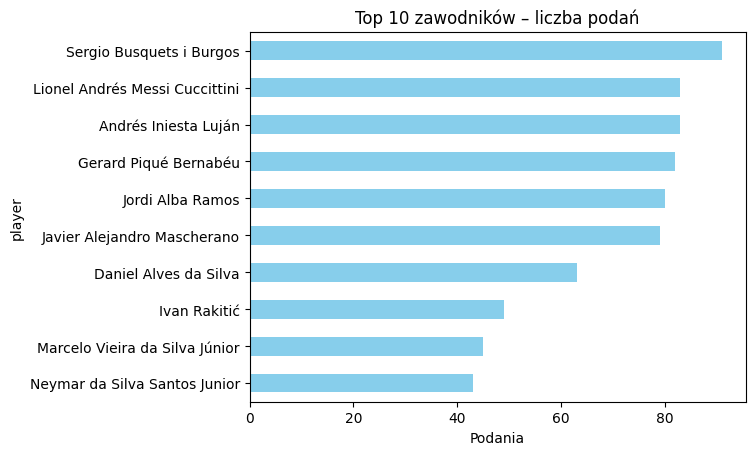

In [221]:
top_passes = events[events['type'] == 'Pass'].groupby('player').size().sort_values(ascending=False).head(10)
top_passes.plot(kind='barh', title='Top 10 zawodników – liczba podań', color='skyblue')
plt.xlabel('Podania')
plt.gca().invert_yaxis()
plt.show()


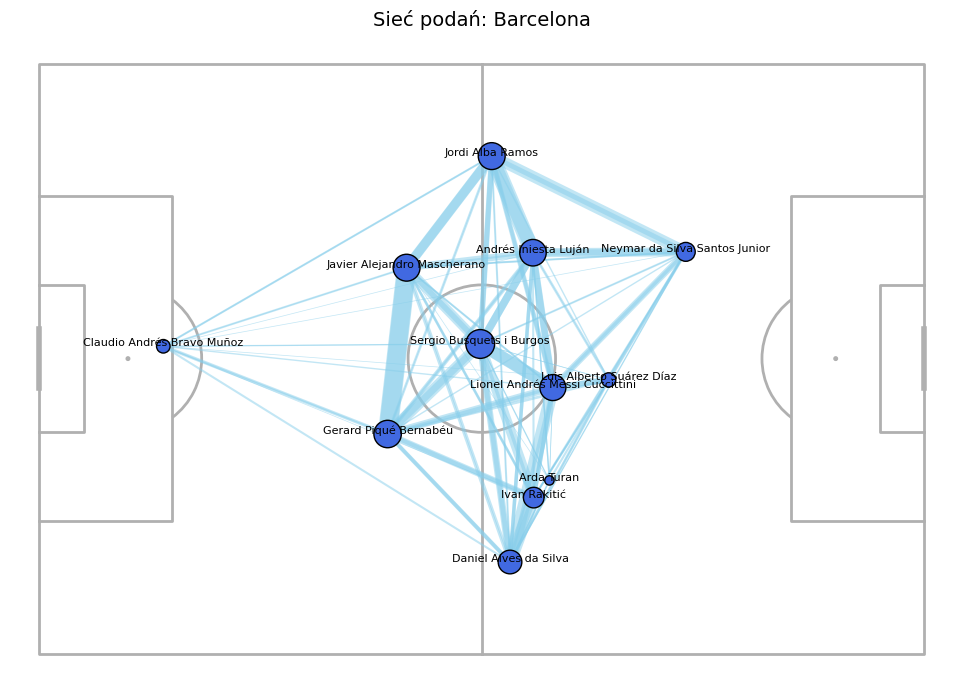

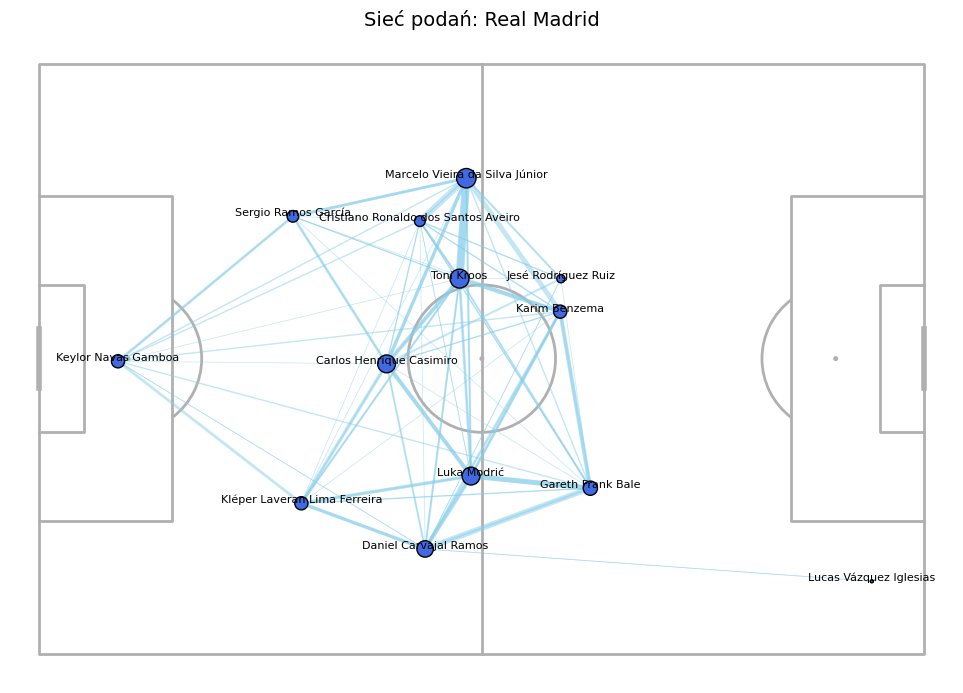

In [223]:
# ===== Sieć podań dla każdej z drużyn =====


# Filtrowanie ukończonych podań z nazwiskami i lokalizacjami
passes = events[
    (events['type'] == 'Pass') &
    (events['pass_outcome'].isnull()) &
    (events['location'].notnull()) &
    (events['pass_end_location'].notnull()) &
    (events['player'].notnull()) &
    (events['team'].notnull())
]

teams = passes['team'].unique()
passes_by_team = {team: passes[passes['team'] == team] for team in teams}

def create_pass_network(passes, team_name):
    # Średnia pozycja każdego gracza
    avg_locs = passes.groupby('player').agg(
        x=('location', lambda locs: np.mean([loc[0] for loc in locs])),
        y=('location', lambda locs: np.mean([loc[1] for loc in locs])),
        count=('player', 'count')
    ).reset_index()

    # Częstotliwość podań między zawodnikami
    combinations = passes.groupby(['player', 'pass_recipient']).size().reset_index(name='count')
    combinations = combinations[combinations['pass_recipient'].notnull()]

    loc_dict = avg_locs.set_index('player')[['x', 'y']].to_dict('index')

    # Rysowanie boiska
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2)
    fig, ax = pitch.draw(figsize=(10, 7))
    plt.title(f'Sieć podań: {team_name}', fontsize=14)

    # Linie podań
    for _, row in combinations.iterrows():
        p1, p2 = row['player'], row['pass_recipient']
        if p1 in loc_dict and p2 in loc_dict:
            x1, y1 = loc_dict[p1]['x'], loc_dict[p1]['y']
            x2, y2 = loc_dict[p2]['x'], loc_dict[p2]['y']
            pitch.lines(x1, y1, x2, y2, ax=ax, lw=row['count'] / 2, color='skyblue', alpha=0.5)

    # Pozycje graczy
    pitch.scatter(avg_locs['x'], avg_locs['y'], s=avg_locs['count']*5, ax=ax,
                  color='royalblue', edgecolors='black', zorder=3)

    for _, row in avg_locs.iterrows():
        pitch.annotate(row['player'], (row['x'], row['y']), ax=ax, fontsize=8, ha='center')

    return fig, ax

# Tworzenie wykresów
for team, team_passes in passes_by_team.items():
    create_pass_network(team_passes, team)
    plt.show()


In [225]:
import pandas as pd
import json

# --- Konwersja kolumny 'cards' z tekstu do listy słowników ---
def parse_cards(card_str):
    if isinstance(card_str, str) and card_str.startswith("["):
        try:
            return json.loads(card_str.replace("'", '"'))
        except json.JSONDecodeError:
            return []
    return card_str

lineups['cards'] = lineups['cards'].apply(parse_cards)

# --- Zamiana DataFrame lineups na słownik drużyn ---
lineups_data = {
    team: group.to_dict(orient="records")
    for team, group in lineups.groupby("team")
}

# --- Filtrujemy zdarzenia z meczu ---
match_events = events.copy()
timeline = []

# --- Gole i samobóje ---
normal_goals = match_events[(match_events['type'] == 'Shot') & (match_events['shot_outcome'] == 'Goal')]
own_goals = match_events[match_events['type'] == 'Own Goal For']
goals = pd.concat([normal_goals, own_goals], ignore_index=True)
goals['minute'] = goals['minute'] + 1

for _, row in goals.iterrows():
    timeline.append({
        'minute': row['minute'],
        'second': row.get('second', 0),
        'team': row.get('team', None),
        'player': row.get('player', None),
        'type': '⚽ Gol' if row['type'] == 'Shot' else '❌ Samobój',
    })

# --- Kartki z lineups_data ---
for team_name, players in lineups_data.items():
    for player in players:
        for card in player.get("cards", []):
            card_type = card.get("card_type")
            time_str = card.get("time", "0:0")
            try:
                minute, second = map(int, time_str.split(":"))
            except:
                minute, second = 0, 0

            symbol = {
                "Yellow Card": "🟡",
                "Second Yellow": "🟡🟡",
                "Red Card": "🔴"
            }.get(card_type, "❗")

            timeline.append({
                'minute': minute + 1,
                'second': second,
                'team': team_name,
                'player': player.get("player_name", "Brak danych"),
                'type': f'{symbol} {card_type}'
            })

# --- Zmiany ---
subs = match_events[match_events['type'] == 'Substitution'].copy()
subs['minute'] = subs['minute'] + 1

for _, row in subs.iterrows():
    timeline.append({
        'minute': row['minute'],
        'second': row.get('second', 0),
        'team': row.get('team', None),
        'player': f"{row.get('player')} ➡️ {row.get('substitution_replacement')}",
        'type': '🔁 Zmiana'
    })

# --- Koniec połów i doliczony czas ---
half_ends = (
    match_events[match_events['type'] == 'Half End']
    .sort_values(['period', 'minute', 'second'])
    .drop_duplicates(subset='period', keep='last')  # tylko ostatni wpis dla każdej połowy
)

for _, row in half_ends.iterrows():
    period = row.get("period", None)
    minute = row.get("minute", 0)
    second = row.get("second", 0)

    if period == 1:
        if minute > 45:
            timeline.append({
                'minute': 45,
                'second': 0,
                'team': '',
                'player': '',
                'type': f'⏱️ Doliczony czas 1. połowy: +{minute - 45} min'
            })
        timeline.append({
            'minute': minute,
            'second': second,
            'team': '',
            'player': '',
            'type': '🔚 Koniec 1. połowy'
        })

    elif period == 2:
        if minute > 90:
            timeline.append({
                'minute': 90,
                'second': 0,
                'team': '',
                'player': '',
                'type': f'⏱️ Doliczony czas 2. połowy: +{minute - 90} min'
            })
        timeline.append({
            'minute': minute,
            'second': second,
            'team': '',
            'player': '',
            'type': '🔚 Koniec meczu'
        })


# --- Tworzymy DataFrame i sortujemy po czasie ---
timeline_df = pd.DataFrame(timeline)
timeline_df = timeline_df.sort_values(by=['minute', 'second']).reset_index(drop=True)

# --- Formatowanie i wyświetlenie ---
timeline_df['czas'] = timeline_df['minute'].astype(str).str.zfill(2) + "'"  # np. 67'
timeline_df = timeline_df[['czas', 'team', 'player', 'type']]
timeline_df.columns = ['⏱ Minuta', 'Drużyna', 'Zawodnik / Akcja', 'Zdarzenie']

display(timeline_df)


,⏱ Minuta,Drużyna,Zawodnik / Akcja,Zdarzenie
0,10',Real Madrid,Sergio Ramos García,🟡 Yellow Card
1,18',Real Madrid,Daniel Carvajal Ramos,🟡 Yellow Card
2,27',Barcelona,Luis Alberto Suárez Díaz,🟡 Yellow Card
3,29',Barcelona,Javier Alejandro Mascherano,🟡 Yellow Card
4,45',,,⏱️ Doliczony czas 1. połowy: +1 min
5,46',,,🔚 Koniec 1. połowy
6,56',Barcelona,Gerard Piqué Bernabéu,⚽ Gol
7,58',Barcelona,Ivan Rakitić,🟡 Yellow Card
8,62',Real Madrid,Karim Benzema,⚽ Gol
9,74',Barcelona,Ivan Rakitić ➡️ Arda Turan,🔁 Zmiana


In [ ]:
starting_xi = events[events['type'] == 'Starting XI']
starting_players = []

for _, row in starting_xi.iterrows():
    team = row['team']
    for player in row['tactics']['lineup']:
        starting_players.append({
            'team': team,
            'player_name': player['player']['name'],
            'jersey_number': player['jersey_number'],
            'position': player['position']['name']
        })

starting_df = pd.DataFrame(starting_players)
display(starting_df)


,team,player_name,jersey_number,position
0,Barcelona,Claudio Andrés Bravo Muñoz,13,Goalkeeper
1,Barcelona,Daniel Alves da Silva,6,Right Back
2,Barcelona,Gerard Piqué Bernabéu,3,Right Center Back
3,Barcelona,Javier Alejandro Mascherano,14,Left Center Back
4,Barcelona,Jordi Alba Ramos,18,Left Back
5,Barcelona,Sergio Busquets i Burgos,5,Center Defensive Midfield
6,Barcelona,Ivan Rakitić,4,Right Center Midfield
7,Barcelona,Andrés Iniesta Luján,8,Left Center Midfield
8,Barcelona,Luis Alberto Suárez Díaz,9,Right Wing
9,Barcelona,Neymar da Silva Santos Junior,11,Left Wing


In [232]:
# Gole
goals = events[(events['type'] == 'Shot') & (events['shot_outcome'] == 'Goal') | (events['type'] == 'Own Goal For')]

goals_df = goals[['minute', 'timestamp', 'team', 'player']].copy()
goals_df['minute'] = goals_df['minute'] + 1
goals_df



,minute,timestamp,team,player
3625,56,00:10:45.095,Barcelona,Gerard Piqué Bernabéu
3626,62,00:16:56.547,Real Madrid,Karim Benzema
3634,85,00:39:36.249,Real Madrid,Cristiano Ronaldo dos Santos Aveiro
